Github location : https://github.com/gt2onew/dtsa5511/tree/main/week4

# **DOWNLOAD DATA from Kaggle**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"onewgt2","key":"4d58020fedd465a398c672160ff7753d"}'}

In [4]:
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! ls -ltrh ~/.kaggle

total 4.0K
-rw------- 1 root root 63 Jul 17 06:16 kaggle.json


In [5]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 165MB/s]


In [6]:
!unzip -o nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
!ls -ltrSh

total 2.0M
-rw-r--r-- 1 root root   63 Jul 17 06:16 kaggle.json
drwxr-xr-x 1 root root 4.0K Jul 13 13:33 sample_data
-rw-r--r-- 1 root root  23K Dec 16  2019 sample_submission.csv
-rw-r--r-- 1 root root 411K Dec 16  2019 test.csv
-rw-r--r-- 1 root root 594K Dec 16  2019 nlp-getting-started.zip
-rw-r--r-- 1 root root 965K Dec 16  2019 train.csv


In [56]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

import keras
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional,Flatten, BatchNormalization, GlobalMaxPool1D

from sklearn.model_selection import train_test_split


# **Step 1 : Brief description of the problem and data**

This kaggle competition targets to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. we have access to a dataset of 10,000 tweets that were hand classified. It's a natural language processing problem.  
Each sample in the train and test set has the following information:  

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

Columns  
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [9]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


We can see from above that the data is very small so this task won't require very heavy computing power and advanced hardware

In [10]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **Step 2 : Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

From above head() function output we can see there are missing values in "keyword" "location" columns, which are also mentioned in https://www.kaggle.com/competitions/nlp-getting-started/data

## **Exploration**

### **Missing values**

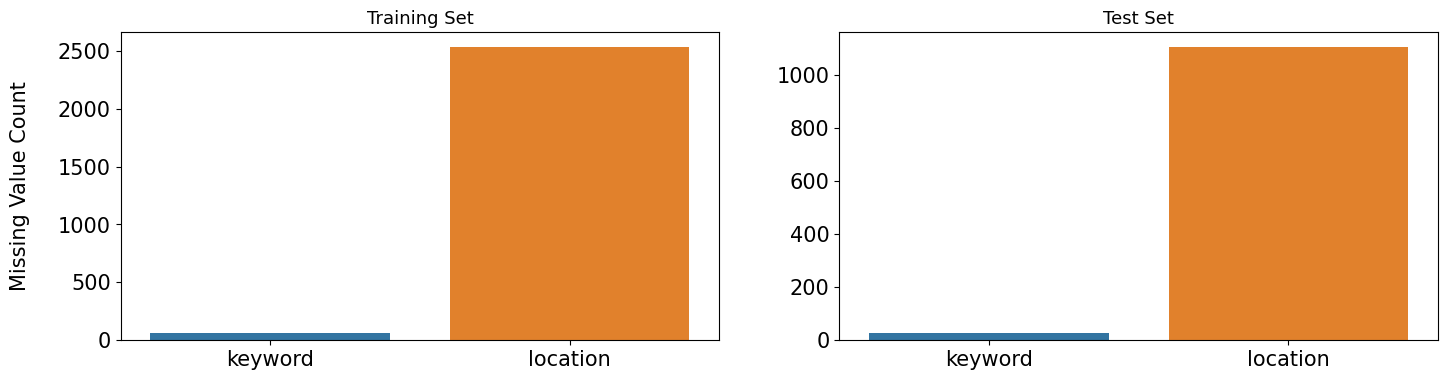

In [12]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

**So many "location" data is missing so it shouldn't be used as a feature**

### **Class distribution**

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

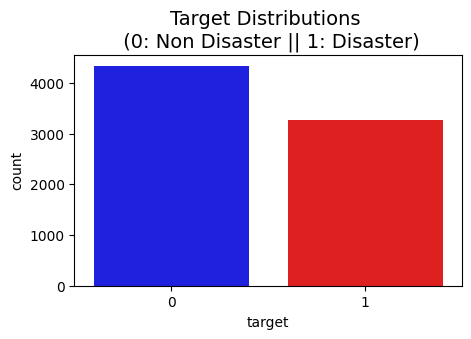

In [13]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=df_train, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

**About 40% positive label and 60% negative label**

### **Keyword distribution per class**

In [14]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')


Number of unique values in keyword = 222 (Training) - 222 (Test)


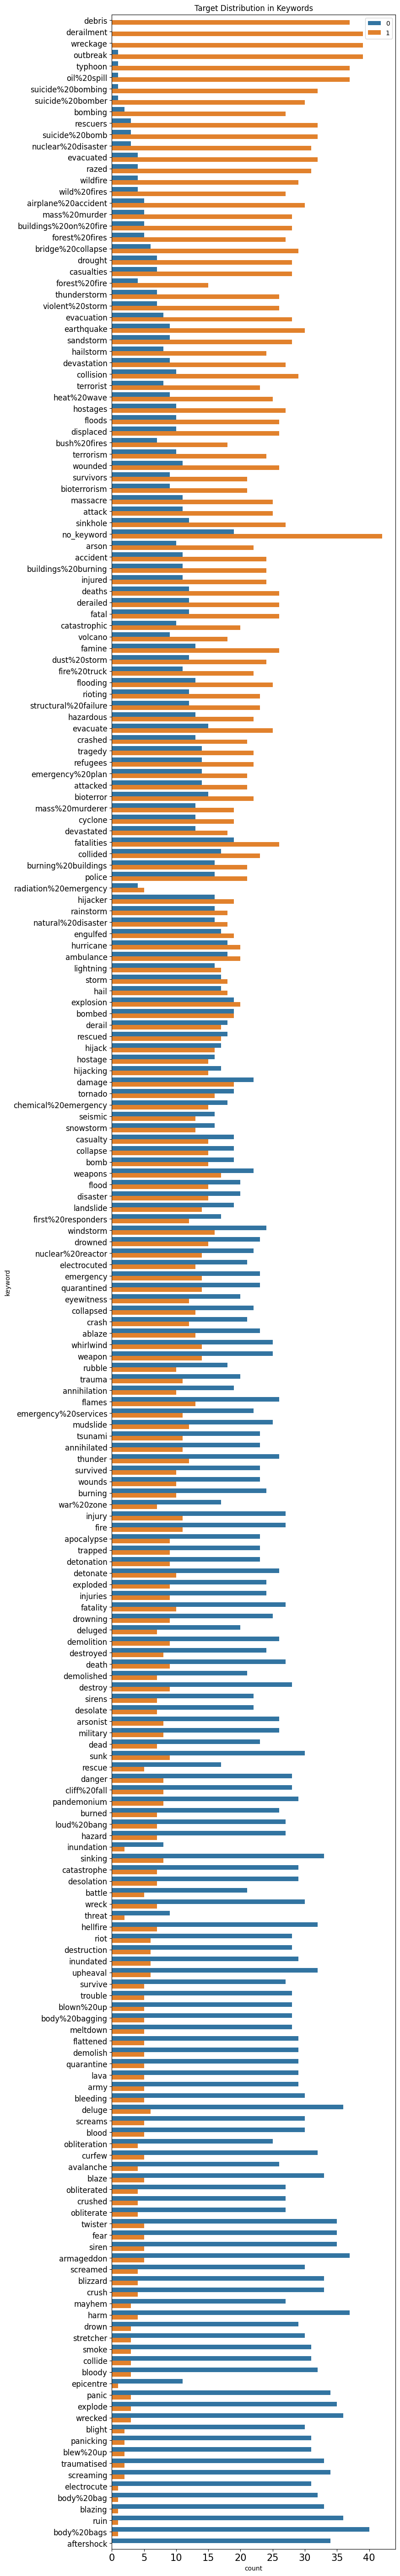

In [15]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

From above graph, we can see there is clear difference between top keywords of disaster and non-disaster tweets. So maybe we can use this "keyword" field as feature.  
Lets further plot top 20 disaster and non disaster keywords

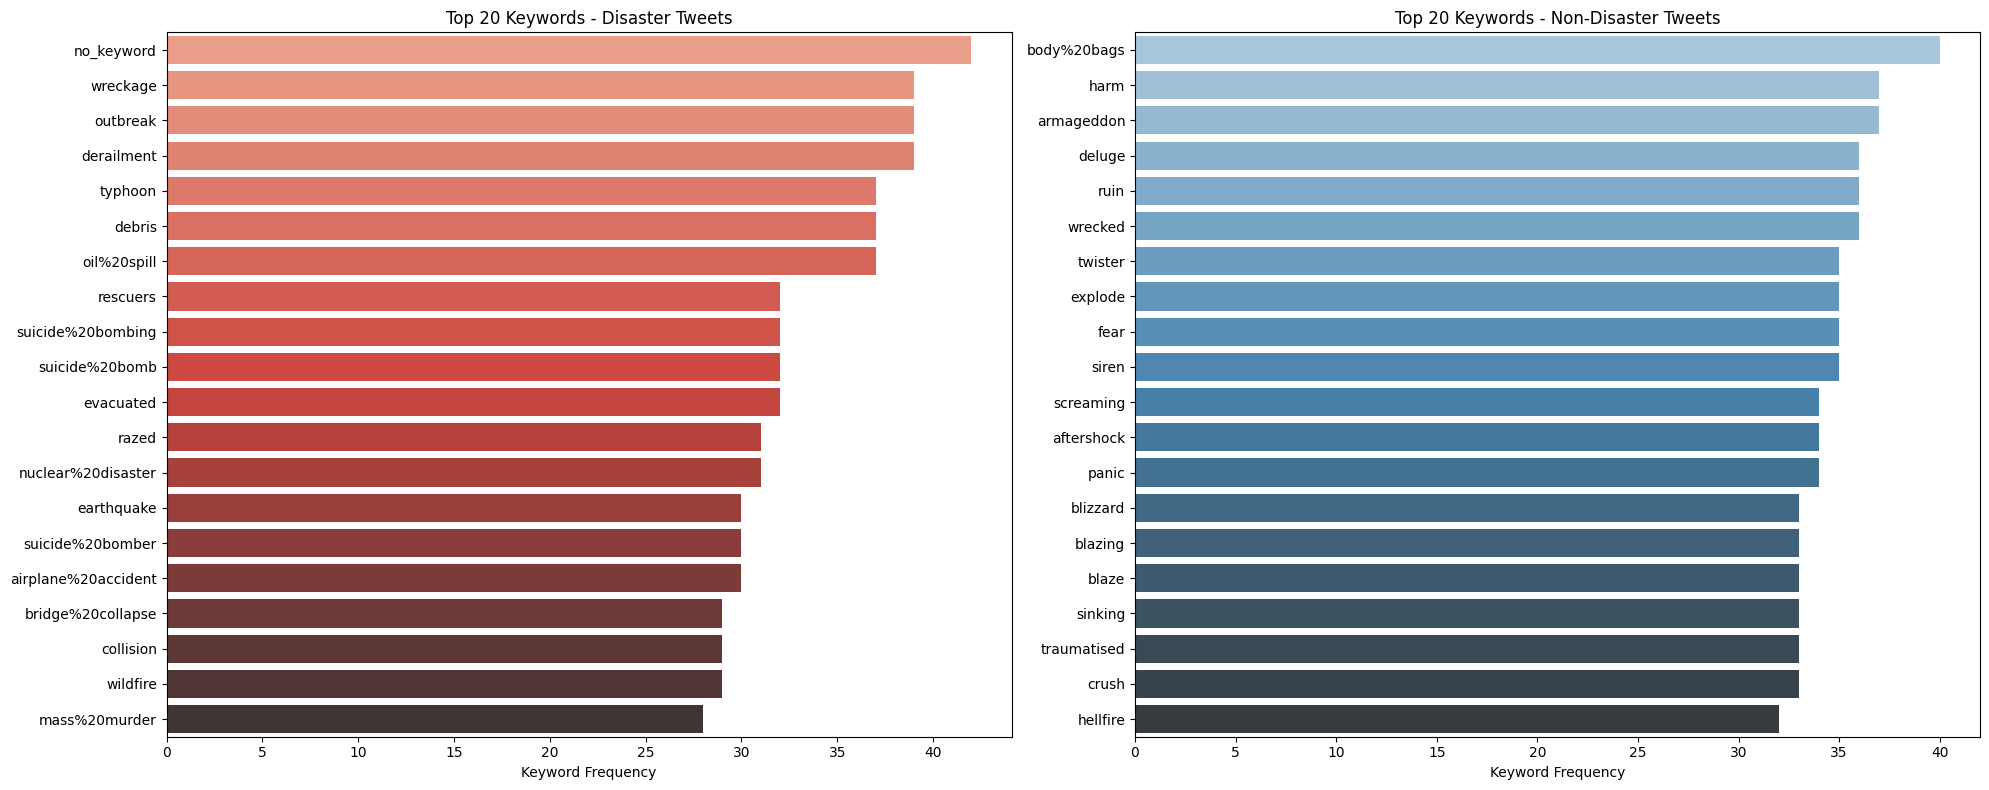

In [16]:
disaster_keywords = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

### **Tweets length per labelling**

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

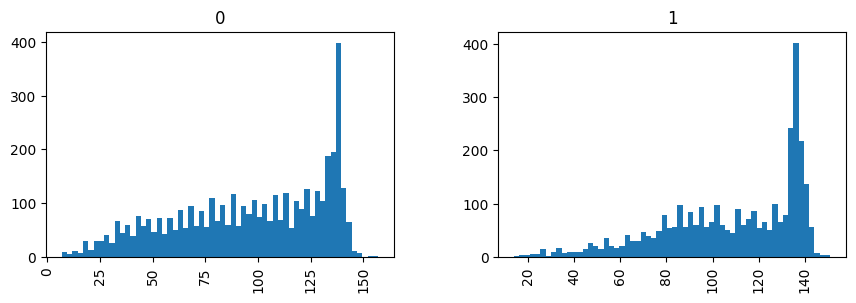

In [17]:
df_train["length"]  = df_train["text"].apply(len)
df_train.hist(column='length', by = 'target',bins =60, figsize= (10,3))


**NO Obvious difference**

### **Average word length**


Text(0.5, 0.98, 'Average word length in each tweet')

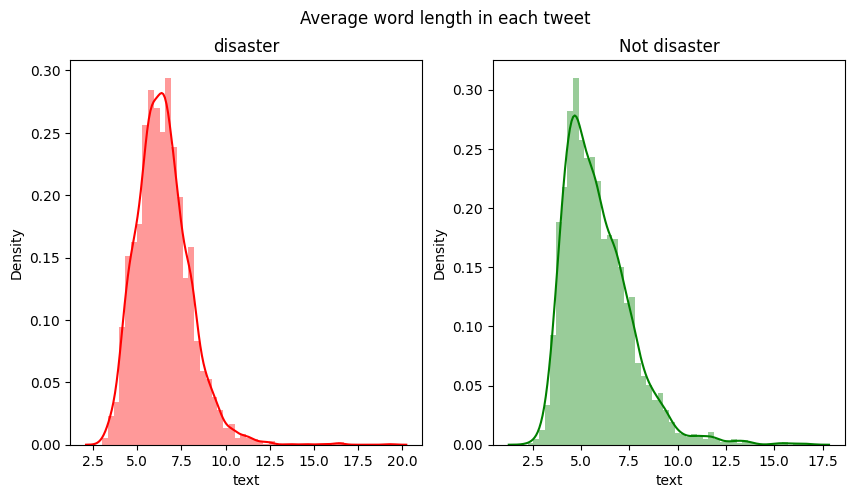

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')


**NO Obvious difference either**

### **Ngram analysis**
Let's check the most common bigrams in tweets.



<Axes: >

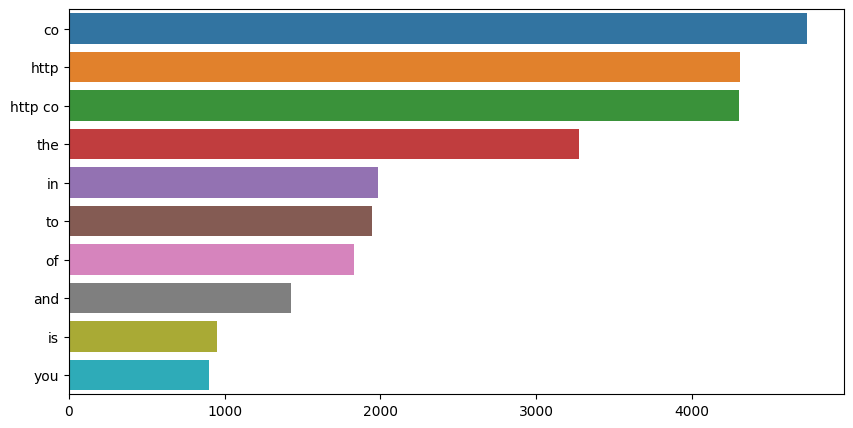

In [19]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)


We can tell that we need a lot of cleaning here before actually implementing the model

## **Data cleaning**

### **Customized cleaning**

In [20]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
# Applying the cleaning function to both test and training datasets
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

In [21]:
df_train['clean_text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: clean_text, dtype: object

### **Removing Punctuations**

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
def remove_punctuation(text):
    cleaned_text = "".join([char for char in text if char not in string.punctuation])
    return cleaned_text

In [24]:
df_train['clean_text'] = df_train['text'].apply(remove_punctuation)
df_test['clean_text'] = df_test['text'].apply(remove_punctuation)

### **Removing Emojis**

In [25]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df_train['clean_text']=df_train['clean_text'].apply(lambda x: remove_emoji(x))

In [26]:
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_emoji(x))

### **Removing URL, HTML tag**

In [27]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df_train['clean_text']=df_train['clean_text'].apply(lambda x: remove_URL(x))
df_train['clean_text']=df_train['clean_text'].apply(lambda x: remove_html(x))


In [28]:
df_test['clean_text']=df_test['clean_text'].apply(lambda x: remove_URL(x))
df_test['clean_text']=df_test['clean_text'].apply(lambda x: remove_html(x))

### **Removing stopwords**


In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
def remove_stopword(text):
    cleaned_text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return cleaned_text

df_train['clean_text']=df_train['clean_text'].apply(lambda x: remove_stopword(x))



In [31]:
df_test['clean_text']=df_test['clean_text'].apply(lambda x: remove_stopword(x))

In [32]:
df_train.head()


,id,keyword,location,text,target,length,clean_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,65,"[13000, people, receive, wildfires, evacuation..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


In [33]:
df_test.head()

,id,keyword,location,text,clean_text
0,0,no_keyword,no_location,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s...","[Heard, #earthquake, different, cities,, stay,..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond,, geese, fleeing, ac..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting., #Spokane, #wildfires]"
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, China, Taiwan]"


## **Word cloud**

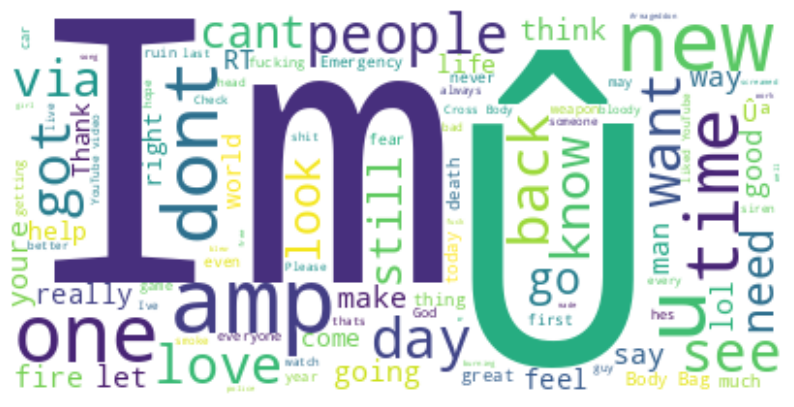

In [34]:
# Create a WordCloud object
wordcloud = WordCloud(background_color='white', colormap='viridis', max_words=100)

# target = 0
wordcloud.generate(' '.join(df_train[df_train["target"] == 0]['clean_text'].apply(lambda x: ' '.join(x))))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



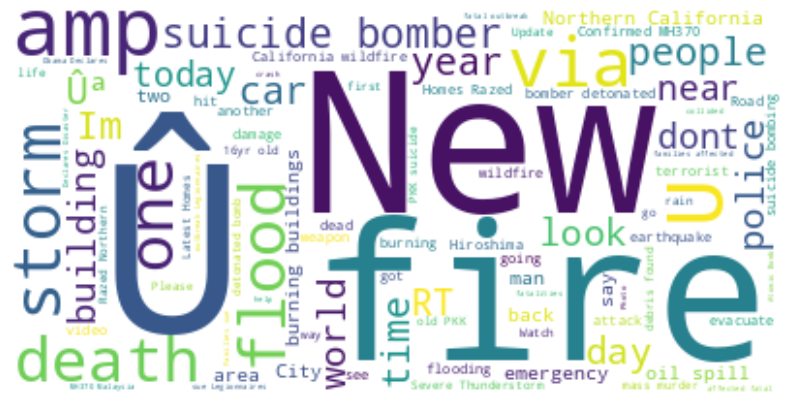

In [35]:
# target = 1
wordcloud.generate(' '.join(df_train[df_train["target"] == 1]['clean_text'].apply(lambda x: ' '.join(x))))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can observe some clear difference that some real "disaster" event word appears in true disaster tweets

# **Step 3 : Modelling**

In [36]:
df_train.clean_text.values

array([list(['Deeds', 'Reason', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us']),
       list(['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', 'Canada']),
       list(['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']),
       ...,
       list(['M194', '0104', 'UTC5km', 'Volcano', 'Hawaii', 'httptcozDtoyd8EbJ']),
       list(['Police', 'investigating', 'ebike', 'collided', 'car', 'Little', 'Portugal', 'Ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['Latest', 'Homes', 'Razed', 'Northern', 'California', 'Wildfire', 'ABC', 'News', 'httptcoYmY4rSkQ3d'])],
      dtype=object)

In [37]:
len(df_train)

7613

## **Embedding**

### **Tokenizer**

Tokenization - the processing of segmenting text into sentences of words. In the process we throw away punctuation and extra symbols too. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing

In [38]:

tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'].values)
X = tokenizer.texts_to_sequences(df_train['clean_text'].values)
X = pad_sequences(X)

In [39]:
vocab_length = len(tokenizer.word_index) + 1


In [40]:
vocab_length

22565

In [41]:
X.shape


(7613, 25)

In [42]:
X[0]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 4390,  716,  152,   54,
       1454, 4391,   13], dtype=int32)

### **Download Glove embeddings and prepare embedding matrix**

Word embedding is a technique used in natural language processing (NLP) to represent words or phrases as numerical vectors in a high-dimensional space. It aims to capture the semantic and syntactic relationships between words and is commonly used as input for various NLP tasks such as language translation, sentiment analysis, and information retrieval.

One popular word embedding algorithm is GloVe, which stands for Global Vectors for Word Representation. GloVe is a model developed by researchers at Stanford University that learns word embeddings by leveraging global statistical information from a large corpus of text. It combines the advantages of two other methods: count-based methods, which capture word co-occurrence statistics, and predictive methods, which predict words based on their context.

GloVe constructs a co-occurrence matrix based on the frequency of word co-occurrences in the training corpus. It then performs dimensionality reduction using matrix factorization techniques to obtain word embeddings. The resulting embeddings encode both the global word co-occurrence statistics and the local context of each word. This allows GloVe to capture the relationships between words based on their semantic and syntactic similarities.

GloVe embeddings have several desirable properties. They exhibit linearity, meaning that vector differences between words can represent meaningful relationships. For example, the vector difference between "king" and "queen" might be similar to the difference between "man" and "woman." GloVe embeddings also preserve word analogies, allowing operations such as "king" - "man" + "woman" to produce a vector close to "queen."

GloVe has been trained on large-scale corpora such as Wikipedia and Common Crawl, making it capable of capturing general semantic relationships between words. The pre-trained GloVe embeddings are publicly available and can be used as a starting point for various NLP applications. Researchers and practitioners can also train custom GloVe embeddings on domain-specific or smaller corpora to capture specific semantic nuances relevant to their tasks.







In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-07-17 06:25:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-17 06:25:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-17 06:25:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [44]:
def load_glove_vectors(glove_file):
    embeddings = {}
    with open(glove_file, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.6B.100d.txt'
glove_vectors = load_glove_vectors(glove_file)

In [45]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
y = df_train['target']

## **LSTM**

### **Basic trial**

In [47]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2256500   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2,337,001
Trainable params: 80,501
Non-trainable params: 2,256,500
_________________________________________________________________
None


In [50]:
history = model.fit(X,y, epochs = 10,validation_split = 0.2, batch_size=32)


Epoch 1/10
191/191 [==============================] - 16s 83ms/step - loss: 0.4525 - accuracy: 0.7954 - val_loss: 0.4249 - val_accuracy: 0.8050
Epoch 2/10
191/191 [==============================] - 16s 84ms/step - loss: 0.4330 - accuracy: 0.8076 - val_loss: 0.4277 - val_accuracy: 0.8076
Epoch 3/10
191/191 [==============================] - 17s 87ms/step - loss: 0.4221 - accuracy: 0.8100 - val_loss: 0.4243 - val_accuracy: 0.8155
Epoch 4/10
191/191 [==============================] - 17s 90ms/step - loss: 0.4071 - accuracy: 0.8246 - val_loss: 0.4426 - val_accuracy: 0.8056
Epoch 5/10
191/191 [==============================] - 16s 85ms/step - loss: 0.3887 - accuracy: 0.8312 - val_loss: 0.4298 - val_accuracy: 0.8017
Epoch 6/10
191/191 [==============================] - 16s 85ms/step - loss: 0.3774 - accuracy: 0.8381 - val_loss: 0.4256 - val_accuracy: 0.8096
Epoch 7/10
191/191 [==============================] - 17s 87ms/step - loss: 0.3596 - accuracy: 0.8407 - val_loss: 0.4697 - val_accuracy:

In [51]:
import matplotlib.pyplot as plt

def plot_hist(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

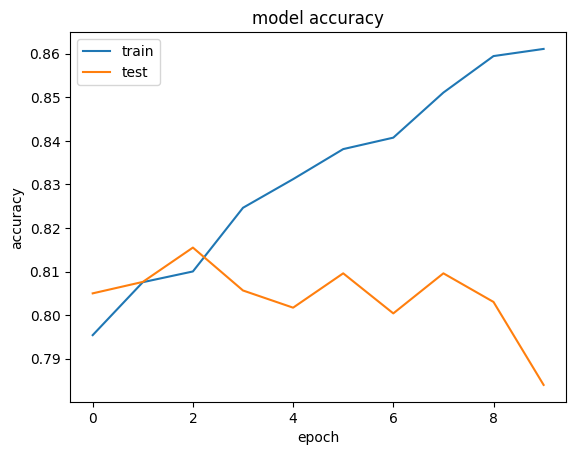

In [52]:
plot_hist(history)

### **Add more LSTM layers**

In [53]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2256500   
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [54]:

history = model.fit(X,y, epochs = 10,validation_split = 0.2 , batch_size=32)


Epoch 1/10
191/191 [==============================] - 43s 188ms/step - loss: 0.4962 - accuracy: 0.7655 - val_loss: 0.4295 - val_accuracy: 0.8063
Epoch 2/10
191/191 [==============================] - 38s 197ms/step - loss: 0.4613 - accuracy: 0.7970 - val_loss: 0.4250 - val_accuracy: 0.8175
Epoch 3/10
191/191 [==============================] - 37s 195ms/step - loss: 0.4502 - accuracy: 0.7997 - val_loss: 0.4239 - val_accuracy: 0.8050
Epoch 4/10
191/191 [==============================] - 38s 201ms/step - loss: 0.4294 - accuracy: 0.8125 - val_loss: 0.4218 - val_accuracy: 0.8102
Epoch 5/10
191/191 [==============================] - 36s 189ms/step - loss: 0.4127 - accuracy: 0.8205 - val_loss: 0.4202 - val_accuracy: 0.8116
Epoch 6/10
191/191 [==============================] - 38s 200ms/step - loss: 0.3959 - accuracy: 0.8284 - val_loss: 0.4259 - val_accuracy: 0.8175
Epoch 7/10
191/191 [==============================] - 35s 182ms/step - loss: 0.3917 - accuracy: 0.8315 - val_loss: 0.4219 - val_ac

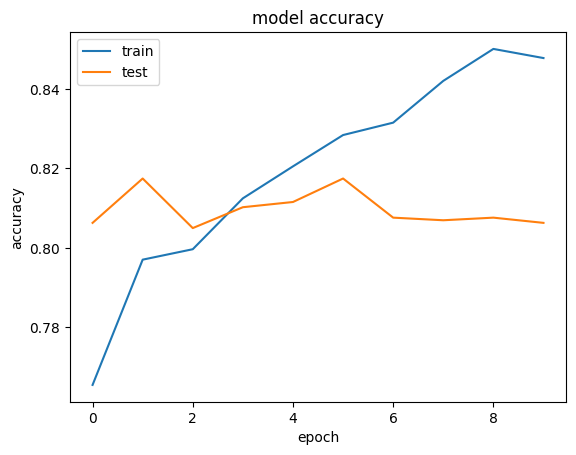

In [55]:
plot_hist(history)

### **Bi-directional LSTM**
In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information.

In [57]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2256500   
                                                                 
 dropout_4 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        160800    
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, None, 200)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 200)              

In [58]:
history = model.fit(X,y, epochs = 10,validation_split = 0.2 , batch_size=32)


Epoch 1/10
191/191 [==============================] - 80s 355ms/step - loss: 0.4849 - accuracy: 0.7780 - val_loss: 0.4214 - val_accuracy: 0.8129
Epoch 2/10
191/191 [==============================] - 73s 385ms/step - loss: 0.4541 - accuracy: 0.7939 - val_loss: 0.4667 - val_accuracy: 0.7991
Epoch 3/10
191/191 [==============================] - 70s 364ms/step - loss: 0.4354 - accuracy: 0.8149 - val_loss: 0.4198 - val_accuracy: 0.8070
Epoch 4/10
191/191 [==============================] - 68s 358ms/step - loss: 0.4248 - accuracy: 0.8151 - val_loss: 0.4056 - val_accuracy: 0.8109
Epoch 5/10
191/191 [==============================] - 68s 357ms/step - loss: 0.4063 - accuracy: 0.8286 - val_loss: 0.4106 - val_accuracy: 0.8155
Epoch 6/10
191/191 [==============================] - 67s 350ms/step - loss: 0.3943 - accuracy: 0.8319 - val_loss: 0.4354 - val_accuracy: 0.8050
Epoch 7/10
191/191 [==============================] - 67s 351ms/step - loss: 0.3875 - accuracy: 0.8268 - val_loss: 0.4561 - val_ac

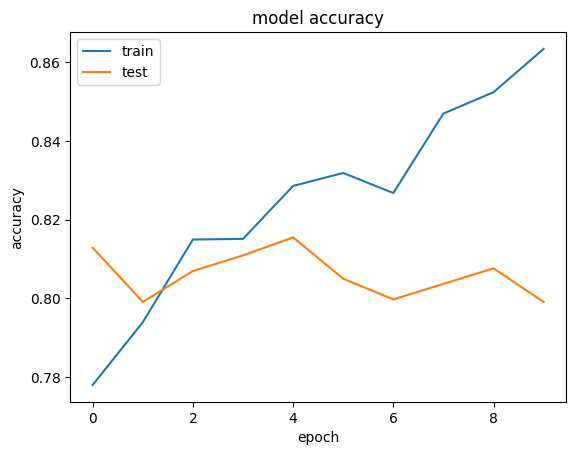

In [59]:
plot_hist(history)

### **Advanced LSTM with BatchNormalization**

In [60]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         2256500   
                                                                 
 dropout_7 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_5 (LSTM)               (None, None, 100)         80400     
                                                                 
 batch_normalization (BatchN  (None, None, 100)        400       
 ormalization)                                                   
                                                                 
 dropout_8 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                      

In [61]:
history = model.fit(X,y, epochs = 10,validation_split = 0.2 , batch_size=32)


Epoch 1/10
191/191 [==============================] - 41s 183ms/step - loss: 0.5596 - accuracy: 0.7484 - val_loss: 0.5740 - val_accuracy: 0.6953
Epoch 2/10
191/191 [==============================] - 34s 181ms/step - loss: 0.4786 - accuracy: 0.7808 - val_loss: 0.4335 - val_accuracy: 0.8063
Epoch 3/10
191/191 [==============================] - 35s 183ms/step - loss: 0.4592 - accuracy: 0.7910 - val_loss: 0.4246 - val_accuracy: 0.8168
Epoch 4/10
191/191 [==============================] - 35s 181ms/step - loss: 0.4357 - accuracy: 0.8067 - val_loss: 0.4201 - val_accuracy: 0.8129
Epoch 5/10
191/191 [==============================] - 34s 181ms/step - loss: 0.4291 - accuracy: 0.8112 - val_loss: 0.4210 - val_accuracy: 0.8175
Epoch 6/10
191/191 [==============================] - 35s 181ms/step - loss: 0.4282 - accuracy: 0.8117 - val_loss: 0.4425 - val_accuracy: 0.8122
Epoch 7/10
191/191 [==============================] - 34s 179ms/step - loss: 0.4160 - accuracy: 0.8151 - val_loss: 0.4695 - val_ac

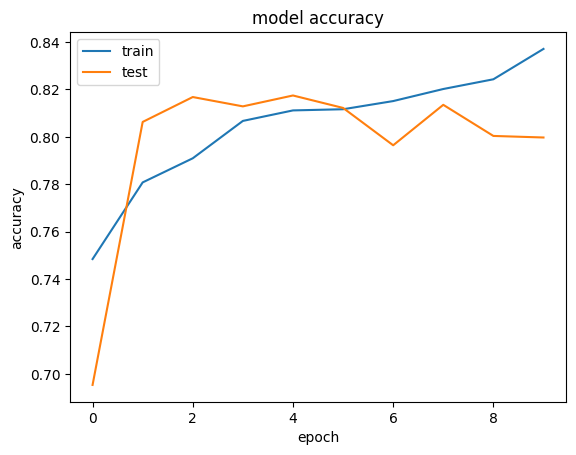

In [62]:
plot_hist(history)

### **Advanced LSTM with tuned learning rate and more epochs**

In [64]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

In [66]:
history = model.fit(X,y, epochs = 20,validation_split = 0.2 , batch_size=32)

Epoch 1/20
191/191 [==============================] - 35s 184ms/step - loss: 0.5919 - accuracy: 0.7092 - val_loss: 0.4874 - val_accuracy: 0.7879
Epoch 2/20
191/191 [==============================] - 34s 179ms/step - loss: 0.4964 - accuracy: 0.7706 - val_loss: 0.4582 - val_accuracy: 0.7932
Epoch 3/20
191/191 [==============================] - 35s 181ms/step - loss: 0.4806 - accuracy: 0.7788 - val_loss: 0.4436 - val_accuracy: 0.7965
Epoch 4/20
191/191 [==============================] - 35s 183ms/step - loss: 0.4711 - accuracy: 0.7893 - val_loss: 0.4358 - val_accuracy: 0.8037
Epoch 5/20
191/191 [==============================] - 34s 180ms/step - loss: 0.4639 - accuracy: 0.7888 - val_loss: 0.4384 - val_accuracy: 0.7991
Epoch 6/20
191/191 [==============================] - 34s 180ms/step - loss: 0.4607 - accuracy: 0.7888 - val_loss: 0.4294 - val_accuracy: 0.8024
Epoch 7/20
191/191 [==============================] - 34s 180ms/step - loss: 0.4582 - accuracy: 0.7939 - val_loss: 0.4245 - val_ac

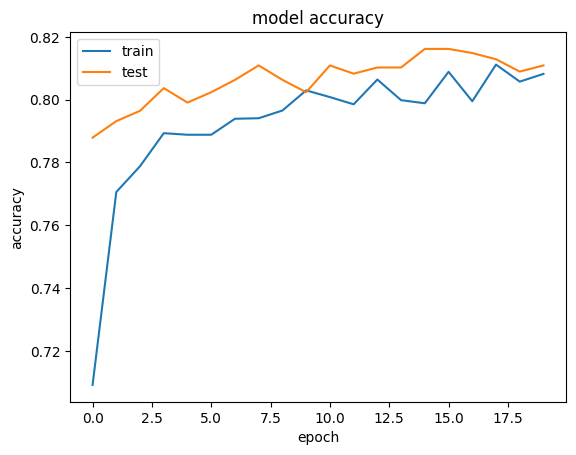

In [67]:
plot_hist(history)

# **Step 4 : Results and Analysis**

We tried 5 different variations of LSTM models above and submitted all the results on the test data to kaggle, the 2nd model "Add more LSTM layers" performs the best with 0.78639 public score and ranks 699.  


*   Add more LSTM layers helps due to potential following reasons: Increased model capacity, Hierarchical feature extraction, Improved model generalization, Enhanced information flow, Better error propagation and Model regularization
*   While bidirectional LSTM (BiLSTM) models have been proven effective in many sequence-related tasks, there are cases where a unidirectional LSTM (ULSTM) may outperform or be preferred over a bidirectional variant. Possible reasons include overfitting, limited future context,etc
*   Batch normalization is a technique commonly used in deep neural networks to improve training stability and speed up convergence. However, applying batch normalization directly to LSTM layers can be challenging and may not always provide significant benefits. Here are a few reasons : Sequence-dependent nature, Internal state dynamics, Limited mini-batch size, Vanishing/exploding gradients
*   The 2nd model seems already at a relatively optimal learning rate and epochs, so tuning the learning rate and adding more epochs did not help



# **Step 5 : Conclusion**

Through this project, I learned:  


*   Basics of Natural language processing
*   WordCloud and other common visualization for text data
*   Text cleaning techniques
*   Word embedding and specifically practiced Glove
*   LSTM and its various tunings for NLP modelling

I also noticed that there are more embedding methods such as Word2Vec, Fasttext and advanced modelling techniques such as Bert, Transformers, etc that I wish to further investigate and apply to this problem



# **Submission**

In [68]:
test_token = tokenizer.texts_to_sequences(df_test['clean_text'].values)
test_token = pad_sequences(test_token)

In [69]:
y_hat = model.predict(test_token).round()

102/102 [==============================] - 2s 12ms/step


In [70]:
submission = pd.read_csv("sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
